In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import json

In [2]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

In [3]:
context = xo.ContextCpu()

In [4]:
num_particles  = 100
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000
nemitt_x = 2.0e-6
nemitt_y = 2.0e-6
sigma_z = 0.224

In [3]:
line = xt.Line.from_json('lines_rf_sweep_sim/sps_chroma_0.5.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [6]:
tidp = install_tidp(line, block_mvt=29e-3)
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [7]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=sigma_z, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.2797155219541792


In [8]:
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# Track during RF sweep:
line.scattering.enable()
line.track(particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.788e-06 per turn.
The bucket height is 0.002982, so this implies the sweep will shift one bucket every 2139.11 turns.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
part.at_turn

array([2795, 2714, 2700, 2695, 2682, 2658, 2653, 2644, 2640, 2635, 2615,
       2581, 2565, 2560, 2543, 2542, 2524, 2523, 2522, 2519, 2518, 2516,
       2509, 2509, 2505, 2498, 2489, 2487, 2451, 2442, 2441, 2438, 2426,
       2426, 2420, 2419, 2417, 2412, 2406, 2399, 2397, 2393, 2381, 2379,
       2359, 2344, 2341, 2339, 2325, 2323, 2319, 2318, 2306, 2300, 2297,
       2275, 2243, 2241, 2241, 2233, 2232, 2224, 2187, 2173, 2172, 2153,
       2144, 2132, 2117, 2116, 2115, 2112, 2097, 2090, 2085, 2065, 2057,
       2055, 2054, 2050, 2044, 2037, 2035, 2033, 2031, 2017, 2010, 2005,
       2001, 1988, 1986, 1970, 1944, 1937, 1891, 1879, 1866, 1839, 1838,
       1831])

In [13]:
turns, counts = np.unique(part.at_turn, return_counts=True)

In [4]:
print(tw.slip_factor)

0.0017935055033301713


In [14]:
sweep_per_turn = sweep/num_turns
f = 200_000_000
delta_per_turn = 1/tw.slip_factor * sweep_per_turn/f

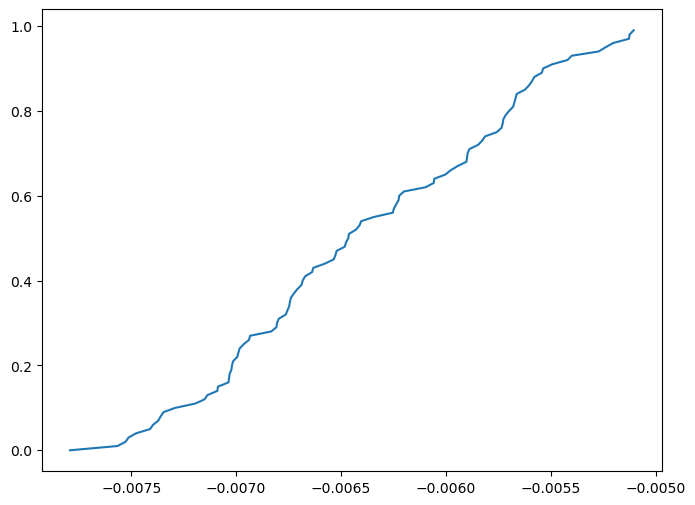

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(-delta_per_turn*turns, 1 - np.cumsum(counts)/num_particles)

In [ ]:
dico = {'sweep_per_turn': sweep_per_turn,
        'at_turn' : part.at_turn.copy().tolist()}

import json
with open(f'RF_sweep_results_{plane}.json', 'w') as fid:
    json.dump(dico, fid, indent=4)